<a href="https://colab.research.google.com/github/flavioschneider/bachelorthesis/blob/master/NN_placecells_autoencoder_firing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Jupiter settings
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
!pip install livelossplot

# Position Encoder

Activation of cell 1: 	 0.00
Activation of cell 2: 	 0.00
Activation of cell 3: 	 0.03
Activation of cell 4: 	 0.00
Activation of cell 5: 	 0.00
Activation of cell 6: 	 0.00
Activation of cell 7: 	 0.00
Activation of cell 8: 	 0.00
Activation of cell 9: 	 0.01
Activation of cell 10: 	 0.06
Activation of cell 11: 	 0.02
Activation of cell 12: 	 0.00
Activation of cell 13: 	 0.00
Activation of cell 14: 	 0.00
Activation of cell 15: 	 0.00
Activation of cell 16: 	 0.02
Activation of cell 17: 	 0.00
Activation of cell 18: 	 0.02
Activation of cell 19: 	 0.00
Activation of cell 20: 	 0.00
Activation of cell 21: 	 0.00
Activation of cell 22: 	 0.00
Activation of cell 23: 	 0.00
Activation of cell 24: 	 0.00
Activation of cell 25: 	 0.00
Activation of cell 26: 	 0.00
Activation of cell 27: 	 0.03
Activation of cell 28: 	 0.00
Activation of cell 29: 	 0.92
Activation of cell 30: 	 0.00
Activation of cell 31: 	 0.17
Activation of cell 32: 	 0.03


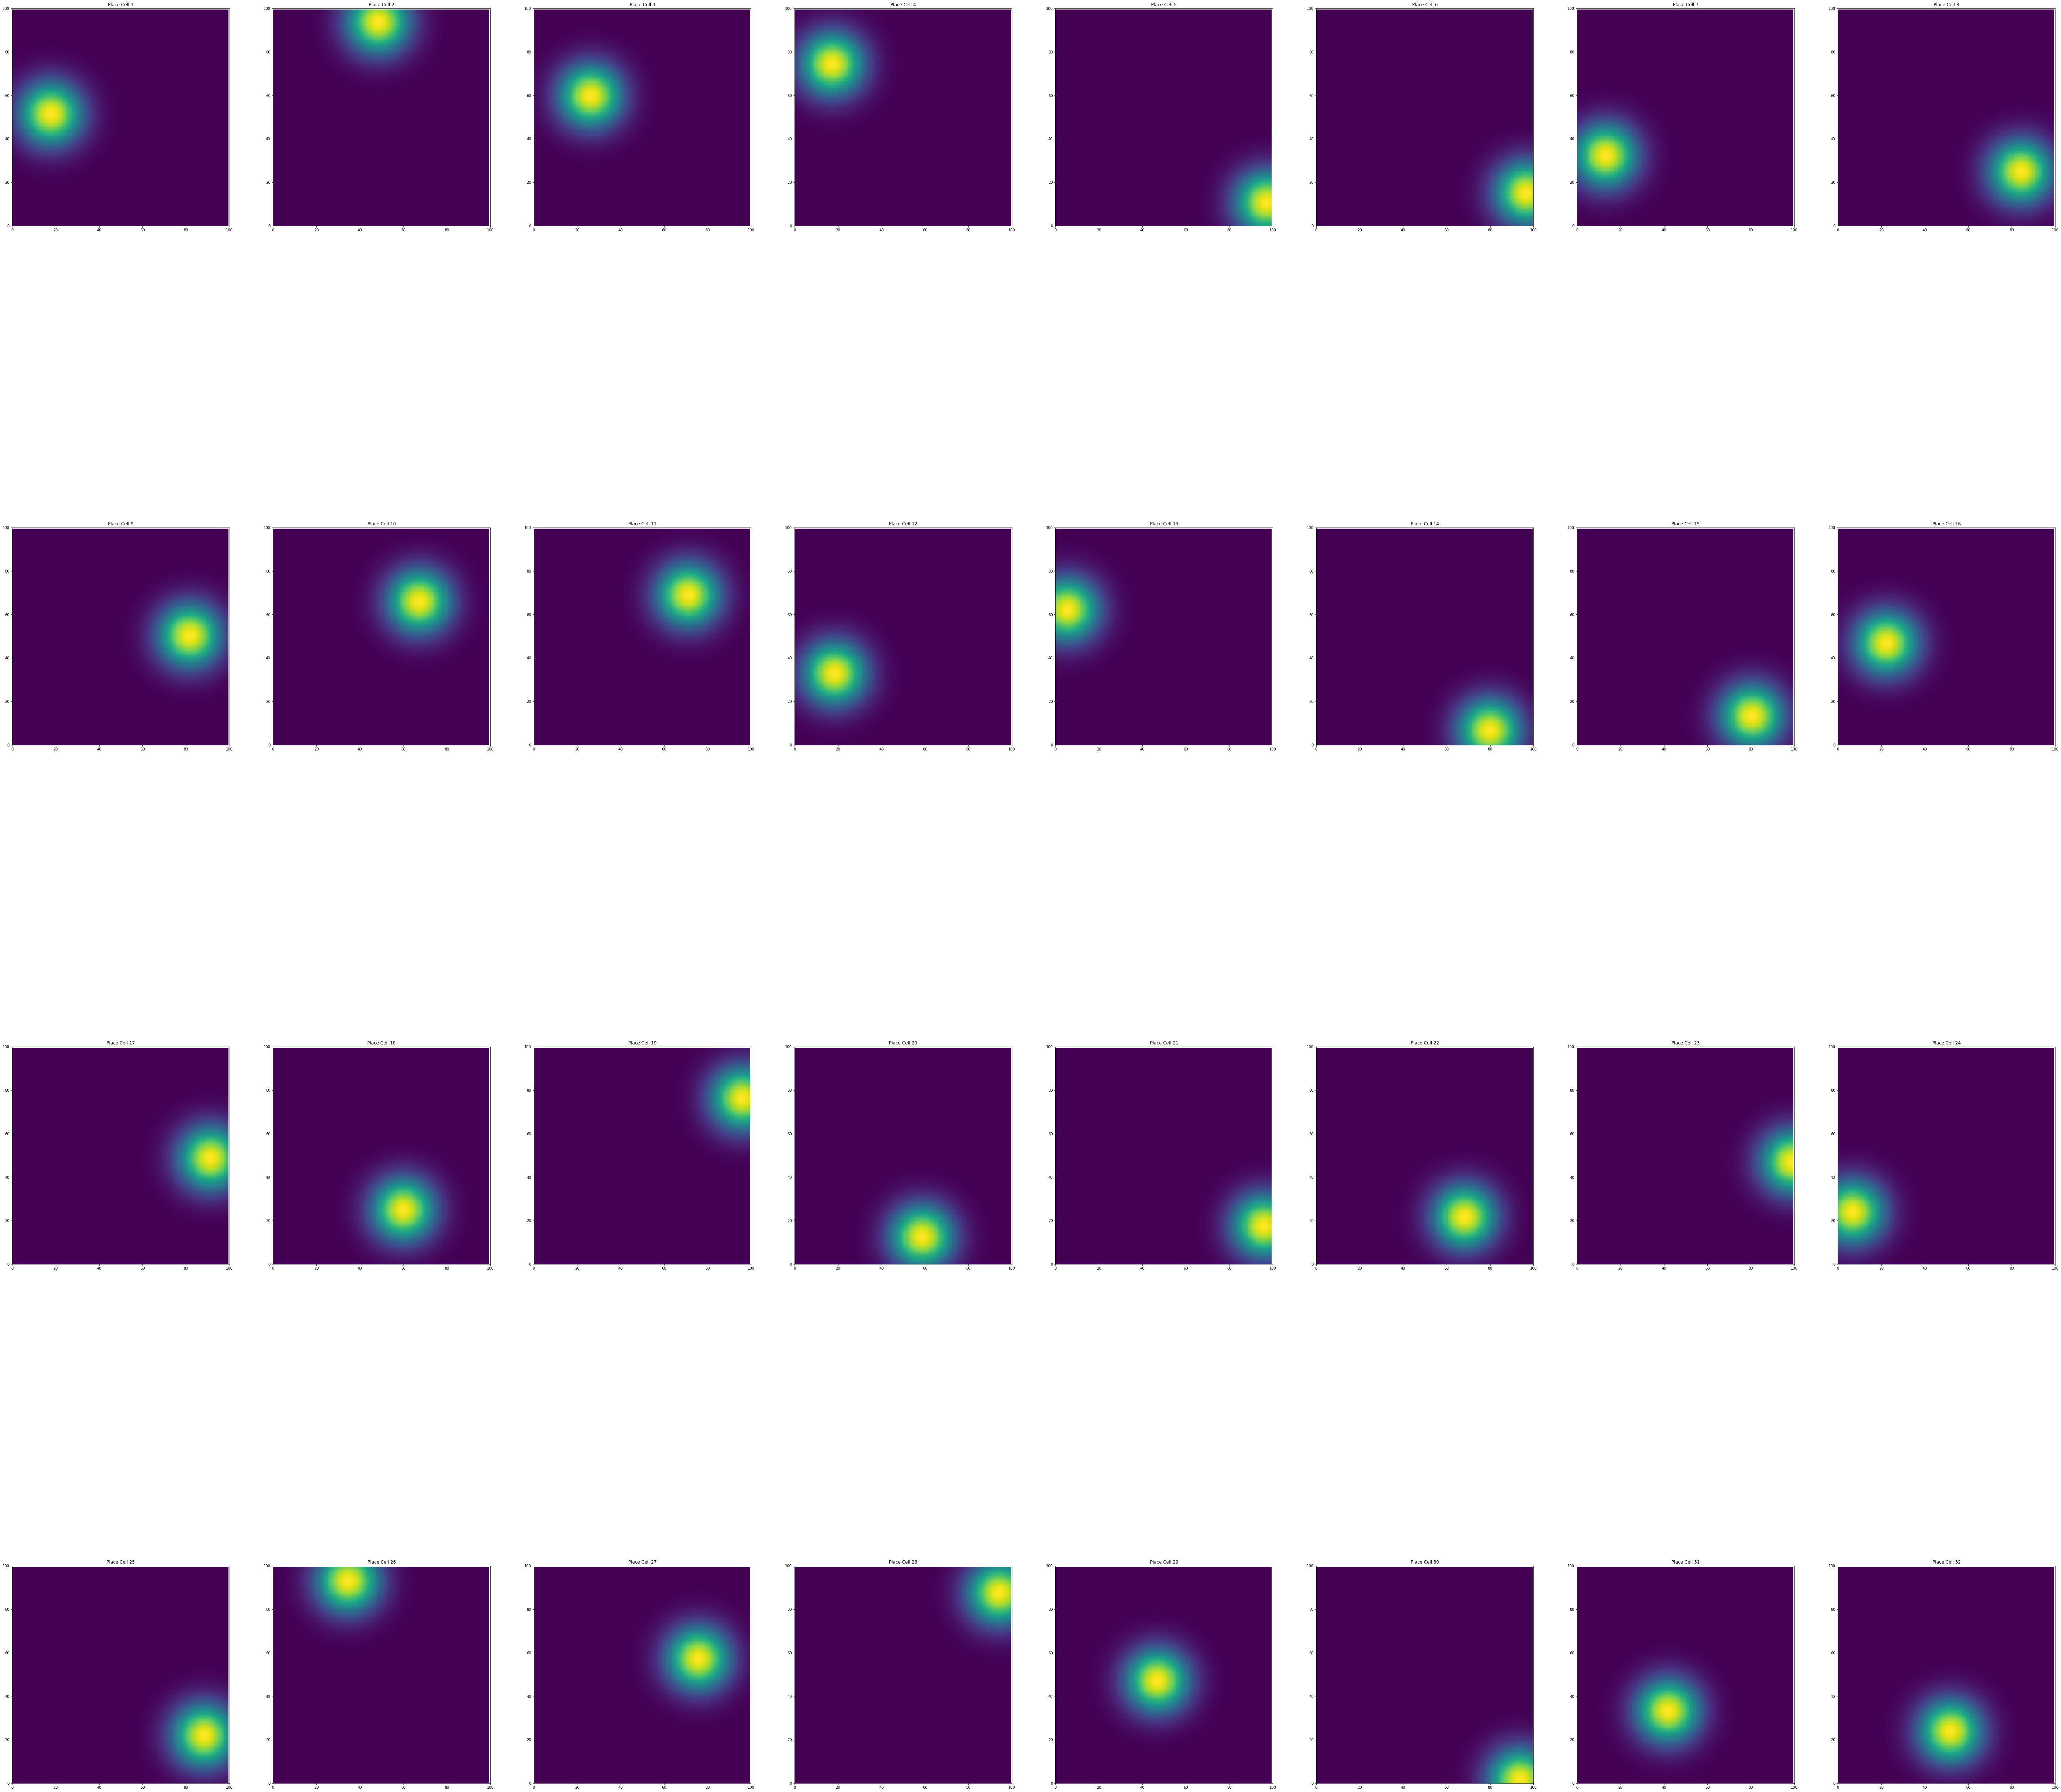

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import math 
from scipy.stats import multivariate_normal

class PositionEncoder(): 

    def __init__(self, res=100, std=0.01, dim=96):
        """
        Parameters
        ----------
        res : int
            The resolution of the arena
        std : float
            The standard deviation of each position center activation        
        std: int  
            The encoding dimension (number of place cells)
        """
        self.res = res
        self.std = std 
        self.dim = dim 
        self.points = self.compute_eval_points([0,1])
        # Center mean points of the gaussians. 
        self.means = means = np.random.rand(self.dim, 2)
        # Place cells activations, precomputed for both speed and visualization.
        self.grids = self.precompute_activations()

    def compute_eval_points(self, range):
        """
        Computes an array of evaluation points of the 2D grid with a size of 
        (res**2, 2).
        """
        x = np.linspace(range[0], range[1], self.res)
        y = np.linspace(range[0], range[1], self.res)
        xx, yy = np.meshgrid(x,y)
        return np.c_[xx.ravel(), yy.ravel()]

    def precompute_activations(self): 
        """
        Evaluates random means and returns a tensor (dim, res, res) with 
        activation values in range [0,1]. 
        """
        grids = np.zeros((self.dim, self.res, self.res))
        cov = np.diag(np.repeat(self.std, 2))

        for i in range(self.dim):
            gaussian = multivariate_normal(mean=self.means[i], cov=cov)
            grids[i] = gaussian.pdf(self.points).reshape((self.res, self.res))
            grids[i] = grids[i] / np.max(grids[i])
    
        return grids;

    def display_grids(self):
        COLS = 8;
        fig, axs = plt.subplots(self.dim//COLS, COLS, figsize=(100, 100))
        i = 0
        for ax in axs.flat:
            ax.imshow(self.grids[i])
            ax.set_ylim(0, self.res)
            ax.set_xlim(0, self.res)
            ax.set_title("Place Cell %s"%(i+1))
            i+=1 
    
    def get_grids(self):
        return self.grids

    def encode_positions(self, positions):
        """
        Given an array of size (N,2) with values in [0,1] will return
        an array of size (N,D) with values in [0,1]. 
        """
        positions = np.multiply(positions, self.res).astype(int); # [[50, 50], [10, 20]]
        N = positions.shape[0]; 
        encoded = np.zeros((N, self.dim))

        for i in range(N):
            encoded[i] = self.grids[:, positions[i,0], positions[i,1]]

        return encoded;


"""
Example: we take the middle point [0.5,0.5] and check the activation of each cell.
""" 
position_encoder = PositionEncoder(std=0.01, dim=32)
grids = position_encoder.get_grids()
position_encoder.display_grids() 
np.set_printoptions(precision=3, suppress=True)
input = [[0.5, 0.5], [0.1,0.2]]
output = position_encoder.encode_positions(input)
for i in range(output.shape[1]):
    print("Activation of cell %s: \t %1.2f" % (i+1, output[0,i]))


# Model

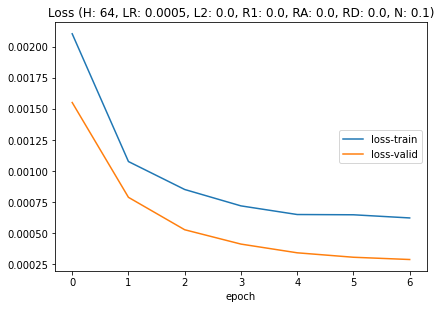

Loss (H: 64, LR: 0.0005, L2: 0.0, R1: 0.0, RA: 0.0, RD: 0.0, N: 0.1)
	loss-train       	 (min:    0.001, max:    0.002, cur:    0.001)
	loss-valid       	 (min:    0.000, max:    0.002, cur:    0.000)
Iter: 7/100, Training Loss: 0.000622051302343607, Validation Loss: 0.00028787690098397434, Loss Mean: 0.024940956323758055


KeyboardInterrupt: ignored

In [0]:
import math 
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

NUM_TRAIN_SAMPLES = 20480
NUM_TEST_SAMPLES = 1024
NUM_SAMPLES = NUM_TRAIN_SAMPLES+NUM_TEST_SAMPLES
BATCH_SIZE = 64

DESCRIPTION = "Autoencoder with encoded place cells position on both input and output, noise and dropout are applied only on the middle hidden layer. Random STD betweeen 0 and 0.5."

PLACE_CELLS_STD = 0.01
INPUT_DIM = 1000
HIDDEN_DIM = 64
OUTPUT_DIM = 200

LOAD_SAVED_MODEL = False 
MODEL_PATH = './model.pt'
NUM_ITER = 100
LR = 0.0005
L2 = 0.0
R1 = 0.0
RA = 0.0
RD = 0.0
NOISE = 0.1

class PointsDataset(torch.utils.data.Dataset):

    def __init__(self, samples, input_dim, output_dim, std): 
        self.samples = samples
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.points = np.zeros((samples, 2))    
        self.input_encoding = np.zeros((samples, input_dim))
        self.output_encoding = np.zeros((samples, output_dim))
        self.input_encoder = PositionEncoder(dim=input_dim, std=std)
        self.output_encoder = PositionEncoder(dim=output_dim, std=std)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        if self.points[idx, 0] == 0:
            self.points[idx] = np.random.uniform(low=0, high=1, size=(2))
            self.input_encoding[idx] = self.input_encoder.encode_positions([self.points[idx]])[0]
            self.output_encoding[idx] = self.output_encoder.encode_positions([self.points[idx]])[0]
        return self.points[idx], self.input_encoding[idx], self.output_encoding[idx]
    
class Model(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(Model, self).__init__() 
        self.input_dim = input_dim        
        self.hidden_dim = hidden_dim        
        self.output_dim = output_dim        
        self.layer1 = nn.Linear(input_dim, hidden_dim)    
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)    
        self.layer3 = nn.Linear(hidden_dim, output_dim)    
        self.dropout = nn.Dropout(p=dropout) 
        self.relu = nn.ReLU() 
        self.sig = nn.Sigmoid() 
        self.tanh = nn.Tanh() 

    # inputs = (batch_size, input_dim)
    def forward(self, inputs):
        state = self.layer1(inputs)
        state = self.dropout(state)
        state = self.relu(state)
        # hidden = self.layer2(hidden)
        outputs = self.layer3(state)
        return outputs, state

dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Model(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, RD)
model.to(dev)

if LOAD_SAVED_MODEL:
    model.load_state_dict(torch.load(MODEL_PATH))

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2)

dataset = PointsDataset(NUM_SAMPLES, INPUT_DIM, OUTPUT_DIM, PLACE_CELLS_STD)
train_set, val_set = torch.utils.data.random_split(
    dataset, 
    [NUM_TRAIN_SAMPLES, NUM_TEST_SAMPLES]
)
train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_set, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

groups = {'Loss (H: %s, LR: %s, L2: %s, R1: %s, RA: %s, RD: %s, N: %s)'%(HIDDEN_DIM,LR,L2,R1,RA,RD,NOISE): ['loss-train', 'loss-valid']}
plotlosses = PlotLosses(groups=groups)

model.train() # Tells the model to use dropout layers

for iter in range(NUM_ITER):
    loss_train = None 
    loss_valid = None 
    loss_mean = None 

    for idx, (point, input_enc, output_enc) in enumerate(train_loader):
        point = point.float().to(dev)
        input_enc = input_enc.float().to(dev)
        output_enc = output_enc.float().to(dev)
        noise = torch.Tensor(BATCH_SIZE, INPUT_DIM).normal_(0, NOISE).float().to(dev)
        optimizer.zero_grad()
        y_pred, states = model(input_enc + noise)
        loss_train = criterion(y_pred, output_enc)
        loss_mean = math.sqrt(loss_train.item())
        loss_train += 1 * (torch.abs(torch.sum(states-torch.abs(states))) / (BATCH_SIZE * HIDDEN_DIM))
        loss_train += RA * ((torch.norm(states)**2) / (BATCH_SIZE * HIDDEN_DIM))     # Penalize high activation of hidden units. 
        loss_train += R1 * (torch.sum(torch.abs(states)) / (BATCH_SIZE * HIDDEN_DIM))     # Penalize high activation of hidden units. 
        loss_train.backward()
        optimizer.step() 

    for idx, (point, input_enc, output_enc) in enumerate(val_loader):
        point = point.float().to(dev)
        input_enc = input_enc.float().to(dev)
        output_enc = output_enc.float().to(dev)
        y_pred, states = model(input_enc)
        loss_valid = criterion(y_pred, output_enc) 
        loss_valid += RA * ((torch.norm(states)**2) / (BATCH_SIZE * HIDDEN_DIM))     # Penalize high activation of hidden units. 
        loss_valid += R1 * (torch.sum(torch.abs(states)) / (BATCH_SIZE * HIDDEN_DIM))    

    if iter % 5 == 0:
        torch.save(model.state_dict(), MODEL_PATH)

    if(iter % 1 == 0):
        plotlosses.update({'loss-train': loss_train.item(), 'loss-valid': loss_valid.item()})
        plotlosses.send()

    print('Iter: %s/%s, Training Loss: %s, Validation Loss: %s, Loss Mean: %s' % (iter+1, NUM_ITER, loss_train.item(), loss_valid.item(), loss_mean))


In [0]:
# Check how it decodes a single point
point = [0.1, 0.2] 
enc = torch.Tensor(encoder.encode_positions([point])[0]).float().to(dev).unsqueeze(0)
noise = torch.Tensor(1, HIDDEN_DIM).normal_(0, 0.1).float().to(dev)
outputs, states = model(enc, noise)
print(outputs)

print(np.max(states.detach().cpu().numpy()))
print(np.min(states.detach().cpu().numpy()))


tensor([[-1.2929e-02, -1.9787e-02,  4.2164e-03,  1.3641e-03,  2.2398e-02,
         -9.9565e-02, -3.0672e-03, -8.2220e-02,  1.2444e-02,  3.2848e-04,
         -7.4731e-03,  1.3019e-01, -2.0658e-03, -1.8343e-02,  4.1371e-03,
          5.7937e-03, -3.7904e-03,  1.8983e-03, -2.1088e-02,  6.6510e-01,
         -9.1745e-03, -1.9931e-02,  4.4534e-01, -6.9423e-04, -1.8995e-03,
         -6.6768e-03,  6.8010e-03,  4.6056e-01, -4.0123e-03,  1.5983e-03,
          1.3688e-03,  3.5245e-03, -2.4188e-02, -7.4755e-03,  3.1901e-03,
          2.0763e-02,  6.6802e-01,  1.7707e-03, -1.6161e-02, -1.6387e-02,
          7.6166e-01,  7.9430e-02,  4.3018e-01,  3.9817e-01,  4.8191e-01,
          6.3448e-02,  2.3730e-03, -5.0636e-03,  2.0019e-03,  1.5917e-03,
          7.5305e-01, -1.7592e-02,  1.4811e-02,  3.3838e-02, -5.1676e-03,
         -1.2224e-02, -2.9865e-02, -3.2275e-03,  1.0474e-02,  5.1152e-03,
         -4.6565e-03, -1.0048e-02, -1.7764e-02, -3.6735e-02, -1.7559e-02,
         -1.7769e-02, -2.9311e-03,  3.

torch.Size([50000, 64])
torch.Size([50000, 2])
Evaluationg model...
Evaluating activation rates...
Unit 1/64
Unit 2/64
Unit 3/64
Unit 4/64
Unit 5/64
Unit 6/64
Unit 7/64
Unit 8/64
Unit 9/64
Unit 10/64
Unit 11/64
Unit 12/64
Unit 13/64
Unit 14/64
Unit 15/64
Unit 16/64
Unit 17/64
Unit 18/64
Unit 19/64
Unit 20/64
Unit 21/64
Unit 22/64
Unit 23/64
Unit 24/64
Unit 25/64
Unit 26/64
Unit 27/64
Unit 28/64
Unit 29/64
Unit 30/64
Unit 31/64
Unit 32/64
Unit 33/64
Unit 34/64
Unit 35/64
Unit 36/64
Unit 37/64
Unit 38/64
Unit 39/64
Unit 40/64
Unit 41/64
Unit 42/64
Unit 43/64
Unit 44/64
Unit 45/64
Unit 46/64
Unit 47/64
Unit 48/64
Unit 49/64
Unit 50/64
Unit 51/64
Unit 52/64
Unit 53/64
Unit 54/64
Unit 55/64
Unit 56/64
Unit 57/64
Unit 58/64
Unit 59/64
Unit 60/64
Unit 61/64
Unit 62/64
Unit 63/64
Unit 64/64
Normalizing...
Plotting...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


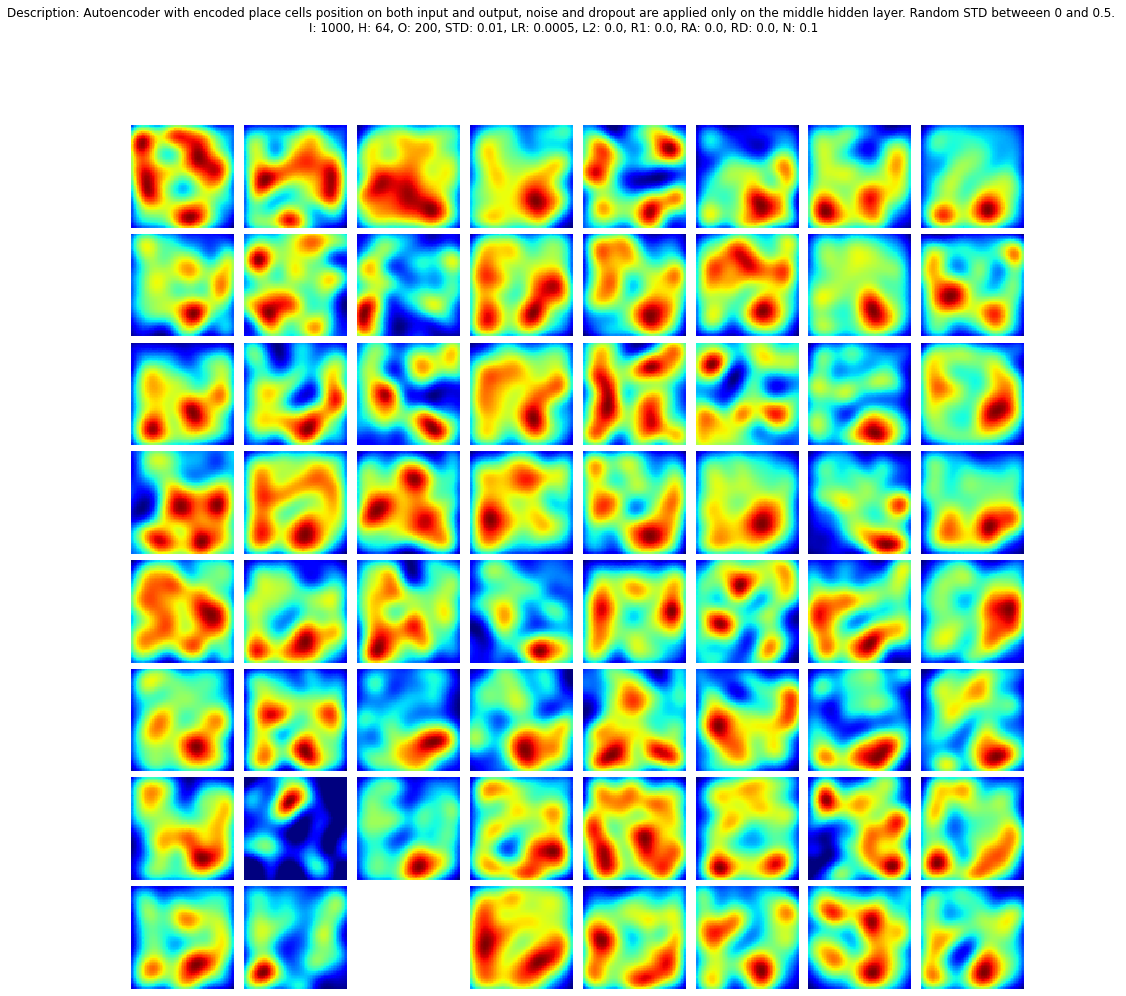

In [0]:
model.eval()
# Check activations of hidden units
ACT_NUM_SAMPLES = 50000
ACT_RESOLUTION = 64

act_dataset = PointsDataset(ACT_NUM_SAMPLES, INPUT_DIM, OUTPUT_DIM, PLACE_CELLS_STD)
act_loader = torch.utils.data.DataLoader(act_dataset, batch_size=ACT_NUM_SAMPLES)

for idx, (point, input_enc, output_enc) in enumerate(act_loader):
    point = point.float().to(dev)
    input_enc = input_enc.float().to(dev)
    output_enc = output_enc.float().to(dev)
    outputs, states = model(input_enc)

print(states.shape)
print(point.shape)

print("Evaluationg model...")
point = point.detach().cpu().numpy()
states = states.detach().cpu().numpy()

"""
The rate stores for each hidden unit how much is active in each cell for all 
points selected, if a point is picked more than once in the same cell the rate
is higher, thus we have to count how many times 
"""
rate = np.zeros([HIDDEN_DIM, ACT_RESOLUTION, ACT_RESOLUTION]) 
count = np.zeros([ACT_RESOLUTION, ACT_RESOLUTION])

print("Evaluating activation rates...")
for unit in range(HIDDEN_DIM):
    for step in range(ACT_NUM_SAMPLES):
        x = point[step, 0] * ACT_RESOLUTION 
        y = point[step, 1] * ACT_RESOLUTION 
        if(int(x) >= ACT_RESOLUTION or int(y) >= ACT_RESOLUTION): continue 
        count[int(x), int(y)] += 1
        rate[unit, int(x), int(y)] += np.abs(states[step, unit])
    print("Unit %s/%s"%(unit+1, HIDDEN_DIM))

print("Normalizing...")     
for x in range(ACT_RESOLUTION):
    for y in range(ACT_RESOLUTION):
        if count[x, y] > 0:
            rate[:, x, y] /= count[x, y]

print("Plotting...")
columns = HIDDEN_DIM // 8
fig, axs = plt.subplots(columns, 8, figsize=(16, 2*columns))
fig.suptitle('Description: %s \nI: %s, H: %s, O: %s, STD: %s, LR: %s, L2: %s, R1: %s, RA: %s, RD: %s, N: %s'%(DESCRIPTION, INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, PLACE_CELLS_STD, LR,L2,R1,RA,RD,NOISE))
i = 0
for ax in axs.flat:
    ax.imshow(rate[i,:,:] / np.max(rate[i,:,:]), interpolation="nearest", cmap="jet")
    ax.axis('off')
    ax.set_aspect('equal')
    i+=1

fig.subplots_adjust(wspace=0.1, hspace=0)
